In [23]:
import json
import jax.numpy as jnp
from gp_oed_surrogate import create_gp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [24]:
# Plot settings:
mpl.rcParams['figure.dpi'] = 200

In [25]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

In [79]:
def plot_function(x, y, z, grid_shape, 
                  z_lims=None, train_pts=None, test_pts=None, title=None, 
                  z_label='Beam Tip Displacement (mm)',
                  num_levels=1000, tick_gap=20):
    
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z))
    levels = jnp.linspace(z_lims[0], z_lims[1], num_levels)
    
    # Reshape inputs:
    x, y, z = x.reshape(grid_shape), y.reshape(grid_shape), z.reshape(grid_shape)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(x, y, z, levels=levels, cmap='coolwarm')
    ticks = jnp.arange(z_lims[0], z_lims[1]+1, tick_gap)
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.set_label(z_label, rotation=270, labelpad=15)
    ax.set_xlabel("Young's Modulus (kPa)")
    ax.set_ylabel('Beam Angle (degrees)')
    fig.patch.set_facecolor('white')
    if train_pts is not None:
        plt.plot(train_pts['E'], train_pts['Beam Angle'], 'x', color='black', markersize=3)
    if test_pts is not None:
        plt.plot(test_pts['E'], test_pts['Beam Angle'], 'x', color='green', markersize=3)
    if title is not None:
        ax.set_title(title, pad=15)
    plt.show()

In [27]:
def create_input(data_dict):
    input_array = jnp.stack((jnp.array(data_dict['E']), jnp.array(data_dict['Beam Angle'])), axis=1)
    return input_array

In [28]:
def create_pointgrid(x_lims, y_lims, x_pts, y_pts):
    # Create list of points:
    x_pts = jnp.linspace(x_lims[0], x_lims[1], x_pts)
    y_pts = jnp.linspace(y_lims[0], y_lims[1], y_pts)
    # Create grid of points:
    y_grid, x_grid = jnp.meshgrid(x_pts, y_pts)
    # Store input:
    pts = {'E': x_grid.flatten(), 
           'Angle': y_grid.flatten(), 
           'input': jnp.stack([x_grid.flatten(), y_grid.flatten()], axis=1)}
    return pts 

# Linear Elastic Beam

## Train GP

In [29]:
# Import linear elastic beam data:
train_dir = "./linear_train.json"
test_dir =  "./linear_test.json"
with open(train_dir) as f:
    linear_train = json.load(f)
with open(test_dir) as f:
    linear_test = json.load(f)

In [37]:
# Train Gaussian process model:
constraints = {"length_0": {">": 10**-1, "<": 10**3}, 
               "length_1": {">": 10**-1, "<": 10**3}, 
               "const": {">": 10**-1, "<": 10**3}}
train_features = create_input(linear_train)
train_labels = jnp.array(linear_train['End Displacement']).reshape(-1,1)
gp = create_gp(kernel, train_features, train_labels, constraints)

11393.8545
5338.1694
1124.8749
1054.1526
743.9271
414.5675
413.09705
314.53098
146.98535
196.03925
131.82788
128.9796
129.35867
135.107
128.9796
263.34015
128.34384
125.86496
124.805664
126.41579
124.476234
133.39964
131.43835
124.476234
130.93567
126.11485
124.38277
127.86957
124.97523
124.34109
121.28497
125.78629
121.28497
121.28497
121.28497
121.28497
121.28497
121.28497
121.28497
121.28497
121.28497
      fun: array(121.28497314)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01067555, -0.9197036 , -0.10789125])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 41
      nit: 13
     njev: 41
   status: 0
  success: True
        x: array([ 366.83589717,   67.01186555, 1000.        ])
3027.482
3036.0337
3040.6382
2970.9907
3127.3145
2970.9907
2977.7695
3081.3428
3089.639
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
2970.9907
      fun: array(2970.99072266)
 hess_inv: 

In [80]:
min_vals, max_vals = jnp.min(train_features, axis=0), jnp.max(train_features, axis=0)
x_lims = [min_vals[1], max_vals[1]]
y_lims = [min_vals[0], max_vals[0]]
x_pts = y_pts = 30
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts)
gp_pred = gp.predict(pred_pts['input'])

## Plot GP

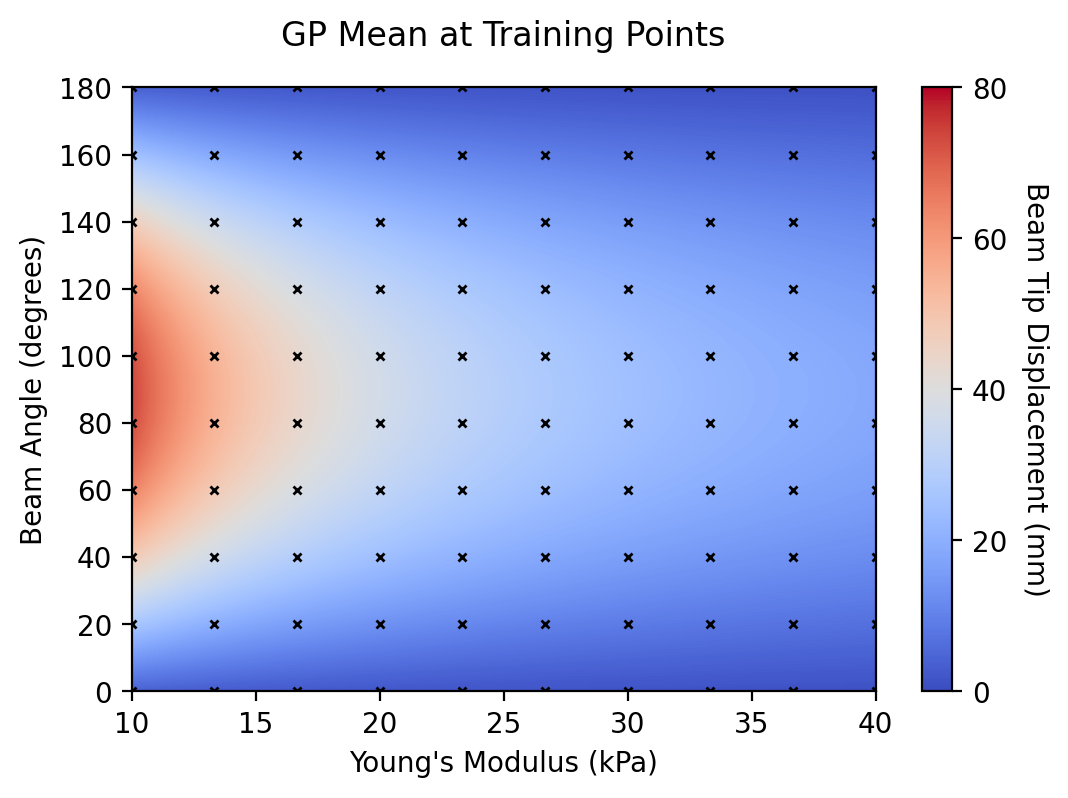

In [81]:
# Plot GP surface:
x_pts = y_pts = 30
grid_shape = (y_pts, x_pts)
title = 'GP Mean at Training Points'
z_lims = (0, 80)
plot_function(pred_pts['E'], pred_pts['Angle'], gp_pred['mean'], grid_shape, 
              train_pts=linear_train, z_lims=z_lims, title=title)

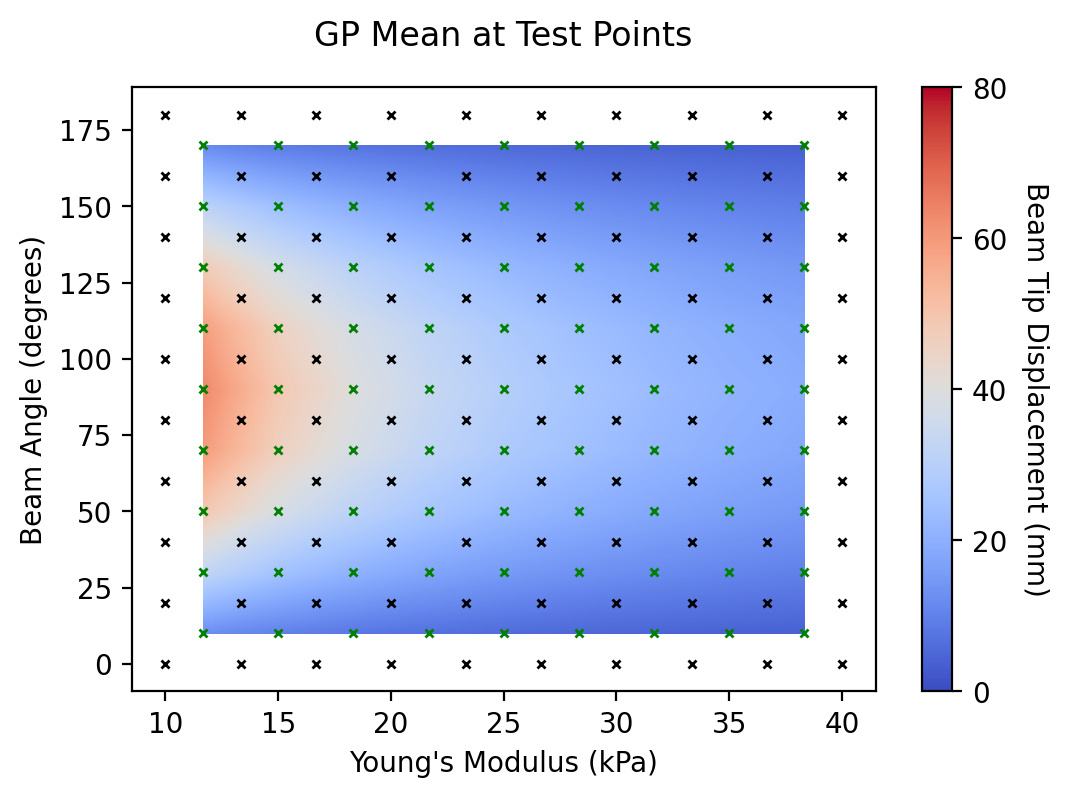

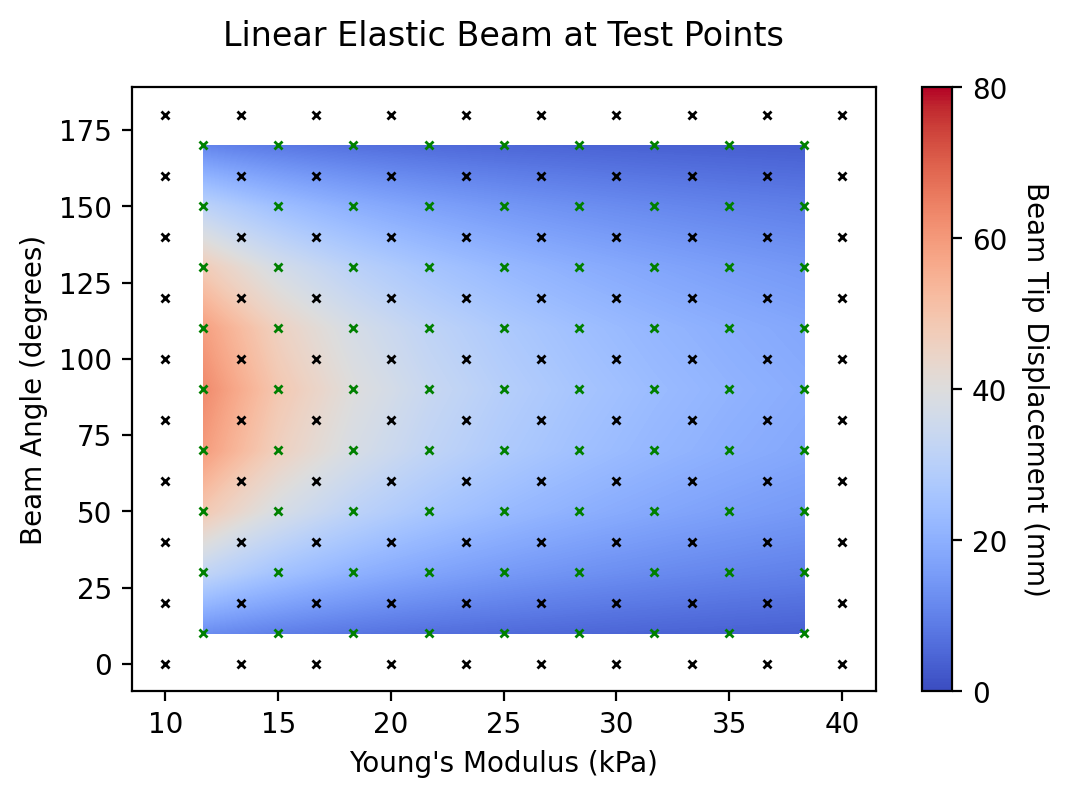

In [82]:
# Compare to test data:
test_features = create_input(linear_test)
grid_shape = (9,9)
gp_pred = gp.predict(test_features)

E_array = jnp.array(linear_test['E'])
angle_array = jnp.array(linear_test['Beam Angle'])
disp_array = jnp.array(linear_test['End Displacement'])

title = 'GP Mean at Test Points'
z_lims = (0, 80)
plot_function(E_array, angle_array, gp_pred['mean'], grid_shape, 
              title=title, z_lims=z_lims, train_pts=linear_train, test_pts=linear_test)
title = 'Linear Elastic Beam at Test Points'
z_lims = (0, 80)
plot_function(E_array, angle_array, disp_array, grid_shape, 
              title=title, z_lims=z_lims, train_pts=linear_train, test_pts=linear_test)

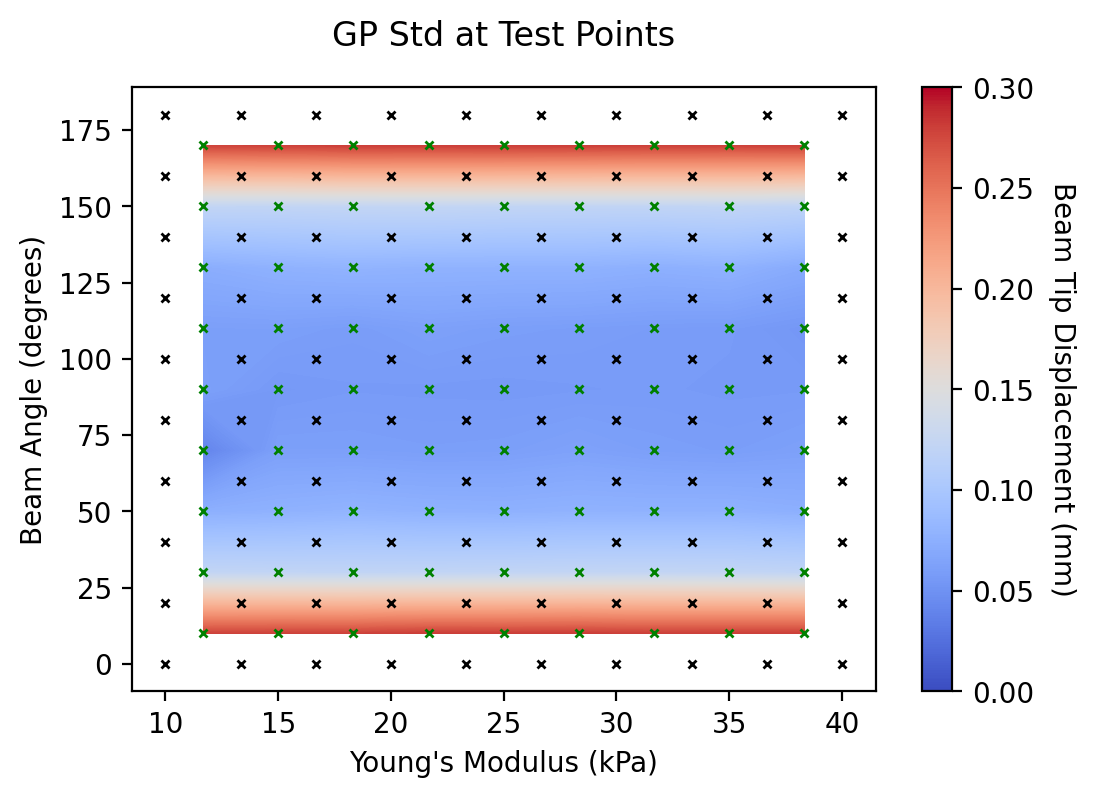

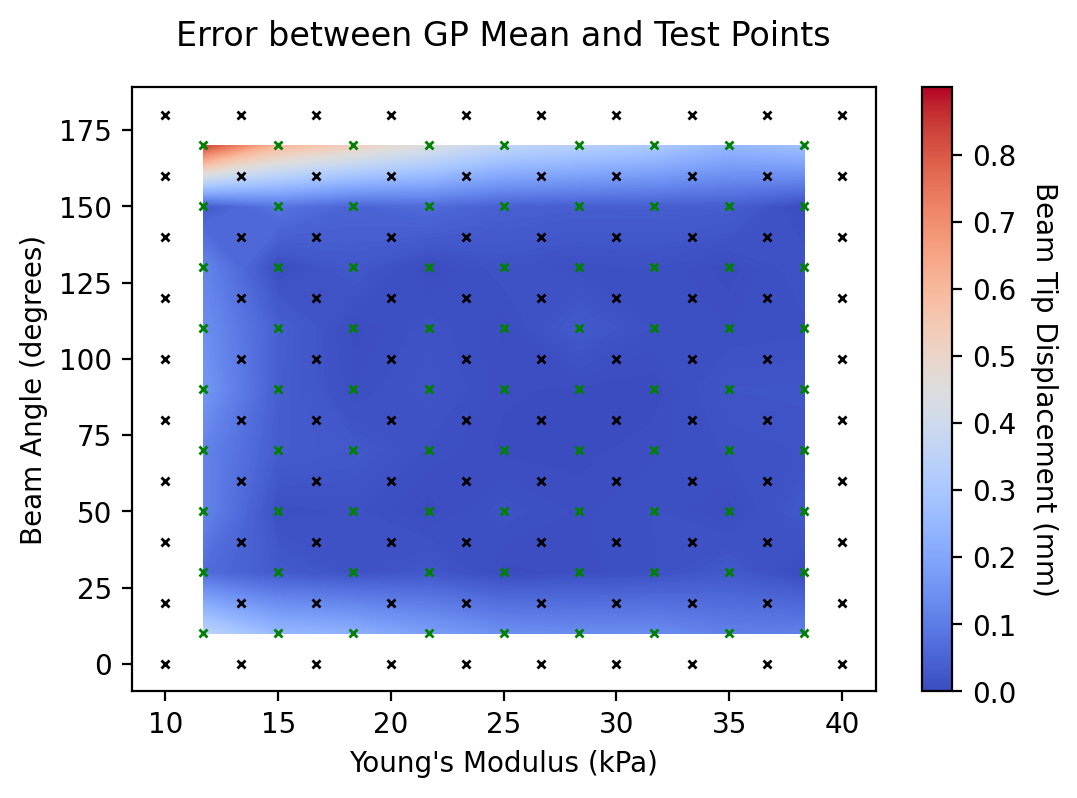

In [83]:
title = 'GP Std at Test Points'
z_label='Std of Beam Tip Displacement (mm)'
z_lims = (0, 0.3)
tick_gap = 0.05
plot_function(E_array, angle_array, gp_pred['var']**0.5, grid_shape, 
              train_pts=linear_train, test_pts=linear_test, title=title, z_lims=z_lims, tick_gap=tick_gap)

title = 'Error between GP Mean and Test Points'
z_label='Difference in Beam Tip Displacement (mm)'
z_lims = (0, 0.9)
tick_gap = 0.1
plot_function(E_array, angle_array, jnp.abs(disp_array - gp_pred['mean']), grid_shape, 
              train_pts=linear_train, test_pts=linear_test, title=title, z_lims=z_lims, tick_gap=tick_gap)

## Plot Derivatives of GP

In [84]:
# Mixed derivative:
min_vals, max_vals = jnp.min(train_features, axis=0), jnp.max(train_features, axis=0)
x_lims = [min_vals[1], max_vals[1]]
y_lims = [min_vals[0], max_vals[0]]
x_pts = y_pts = 30
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts)

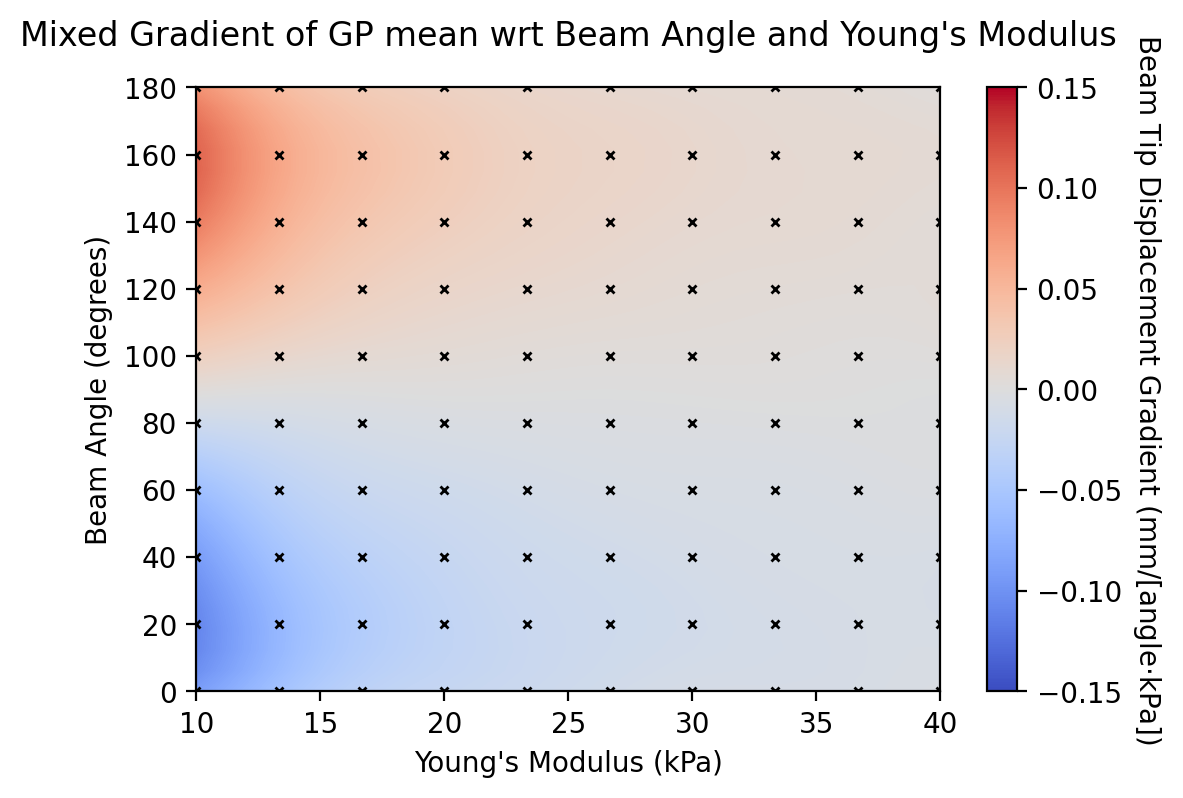

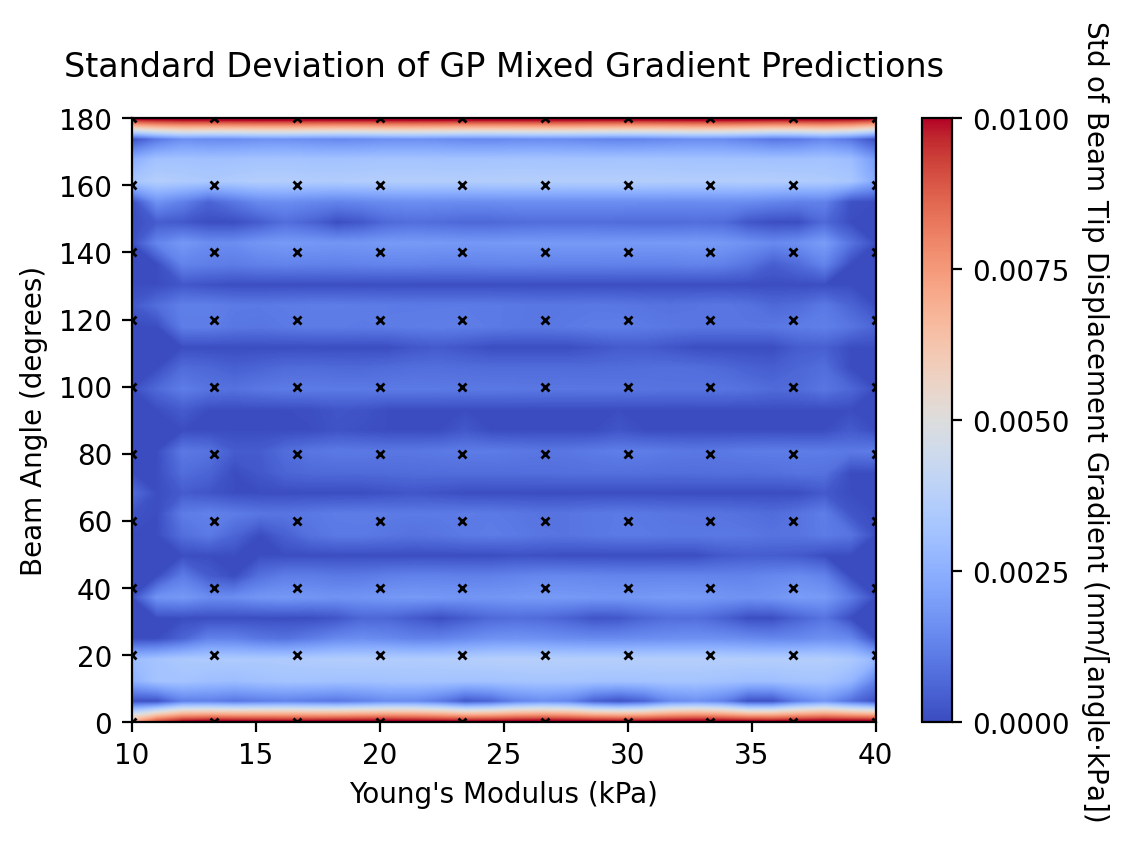

In [94]:
grad = ({'idx': [0], 'order':1}, {'idx': [1], 'order':1})
gp_pred = gp.predict(pred_pts['input'], grad=grad)
grid_shape = (y_pts, x_pts)
title = "Mixed Gradient of GP mean wrt Beam Angle and Young's Modulus"
z_lims=(-0.15, 0.15)
z_label='Beam Tip Displacement Gradient (mm/[angle$\cdot$kPa])'
tick_gap=0.05
plot_function(pred_pts['E'], pred_pts['Angle'], gp_pred['mean'], grid_shape, 
              train_pts=linear_train, title=title, tick_gap=tick_gap, z_label=z_label, z_lims=z_lims)

title = "Standard Deviation of GP Mixed Gradient Predictions"
z_lims=(0, 1e-2)
z_label='Std of Beam Tip Displacement Gradient (mm/[angle$\cdot$kPa])'
tick_gap=2.5e-3
plot_function(pred_pts['E'], pred_pts['Angle'], gp_pred['var']**0.5, grid_shape, 
              train_pts=linear_train, title=title, tick_gap=tick_gap, z_label=z_label, z_lims=z_lims)